#  QF627  Take-Home Assessment - Group 12 | Nov 2024

In [2]:
import numpy as np
import pandas as pd

import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <a id = "top"> 🎄  </a> <font color = "red"> Table of Contents 🎄</a> </font>

# [PART1. TRADING STRATEGY](#part1)
### [1. Import SPY & Data Split](#p1)
### [1.1 Trend Strategy: Simple MA + MACD](#p1.1) 
### [1.2 Mean Reversion Strategy: Bollinger Bands](#p1.2) 
### [1.3 Machine Learning](#p1.3) 
### [Other. Momentum Strategy: MACD + RSI](#p1.4) 
### [Other. Agnes Clustering](#p1.5) 

# [PART2. BACKTESTING AND PERFORMANCE](#p2)


# [PART3. EXECUTIVE SUMMARY](#p3)


# [PART4. SELF-CRITIQUE](#p4)

# [Extra Reading](#p5)

# [Contribution Statement](#p6)



# <a id = "part1"> </a> <font color = "green"> PART1. TRADING STRATEGY </font>  [back to table of contents](#top)

## <a id = "p1">1. </a> <font color = "green"> IMPORT SPY & Data Split </font> [back to table of contents](#top)

In [7]:
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)

SPY = yf.download("SPY", start, end)
# SPY = SPY[["Adj Close"]]
# SPY.copy()


# SPY daily log return
SPY.loc[:, "daily_log_return"] = np.log(SPY["Adj Close"] / SPY["Adj Close"].shift(1))

SPY

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,daily_log_return
Date,,,,,,,
2005-11-01,120.580002,120.900002,120.220001,120.489998,83.991142,66365100,NaN
2005-11-02,120.169998,121.750000,120.129997,121.750000,84.869492,74012300,0.010403
2005-11-03,122.150002,122.660004,121.750000,122.269997,85.231934,84897600,0.004261
2005-11-04,122.400002,122.459999,121.550003,122.110001,85.120415,59156000,-0.001309
2005-11-07,122.370003,122.620003,121.849998,122.230003,85.204071,46765400,0.000982
...,...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900,0.002160
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200,-0.000345
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700,0.003087


In [8]:
#Split training (80%) and backtesting (20%)
validation_size = 0.20
train_size = int(len(SPY) * (1 - validation_size))
train_data, test_data = SPY[:train_size].copy(), SPY[train_size:].copy()

test_data.head()

,Open,High,Low,Close,Adj Close,Volume,daily_log_return
Date,,,,,,,
2021-01-12,378.890015,379.859985,376.359985,378.769989,358.928864,52547700,0.000211
2021-01-13,378.690002,380.859985,377.850006,379.790009,359.895477,45303600,0.002689
2021-01-14,380.589996,381.130005,378.100006,378.459991,358.635071,49989100,-0.003508
2021-01-15,376.720001,377.579987,373.700012,375.700012,356.019714,107160000,-0.007319
2021-01-19,378.339996,379.230011,376.750000,378.649994,358.815186,51233300,0.007821


## <a id = "p1.1">1.1 </a> <font color = "green"> Trend Strategy: Simple MA + MACD </font> [back to table of contents](#top)

In [10]:
def calculate_sma(data, short_window=10, long_window=200):
  
    data["short_SMA"] = SPY["Adj Close"].rolling(window=short_window).mean()
    data["long_SMA"] = SPY["Adj Close"].rolling(window=long_window).mean()
    
    return data


def calculate_macd(data, short_span=12, long_span=26, signal_span=9):
    
    data["short_EWM"] = SPY["Adj Close"].ewm(span=short_span).mean()
    data["long_EWM"] = SPY["Adj Close"].ewm(span=long_span).mean()
    data["MACD"] = data["short_EWM"] - data["long_EWM"]
    data["MACD_signal"] = data["MACD"].ewm(span=signal_span).mean()
    
    return data

In [11]:
#Split training (80%) and backtesting (20%)
train_datasma, test_datasma = SPY[:train_size].copy(), SPY[train_size:].copy()


# SMA train&test data
train_datasma = calculate_sma(train_datasma, short_window=10, long_window=200)
test_datasma = calculate_sma(test_datasma, short_window=10, long_window=200)

# MACD train&test data
train_datasma = calculate_macd(train_datasma, short_span=12, long_span=26, signal_span=9)
test_datasma = calculate_macd(test_datasma, short_span=12, long_span=26, signal_span=9)

In [12]:
# Set position based on SMA + MACD signal (buy=1, sell=-1)
train_datasma["SMA_signal"] = np.where(train_datasma["short_SMA"] > train_datasma["long_SMA"], 1, -1)
train_datasma["MACD_signal"] = np.where(train_datasma["MACD"] > train_datasma["MACD_signal"], 1, -1)
train_datasma["position"] = np.where((train_datasma["SMA_signal"] == 1) | (train_datasma["MACD_signal"] == 1), 1, -1)

test_datasma["SMA_signal"] = np.where(test_datasma["short_SMA"] > test_datasma["long_SMA"], 1, -1)
test_datasma["MACD_signal"] = np.where(test_datasma["MACD"] > test_datasma["MACD_signal"], 1, -1)
test_datasma["position"] = np.where((test_datasma["SMA_signal"] == 1) | (test_datasma["MACD_signal"] == 1), 1, -1)

## <a id = "p1.2">1.2 </a> <font color = "green"> Mean Reversion Strategy: Bollinger Bands </font> [back to table of contents](#top)

In [14]:
test_data_bollinger = SPY[train_size:].copy()

In [15]:
test_data_bollinger['SMA_21'] =\
(
    test_data_bollinger["Adj Close"]
    .rolling(window = 21)
    .mean()
)

test_data_bollinger["STDev_21"] =\
(
    test_data_bollinger["Adj Close"]
    .rolling(window = 21)
    .std()
)

test_data_bollinger['range_upper'] =\
(
    test_data_bollinger['SMA_21']
    +
    test_data_bollinger['STDev_21'] * 2
)

test_data_bollinger['range_lower'] =\
(
    test_data_bollinger['SMA_21']
    -
    test_data_bollinger['STDev_21'] * 2
)

test_data_bollinger['distance'] =\
(
    test_data_bollinger["Adj Close"] - test_data_bollinger['SMA_21']
)

Text(0.5, 1.0, 'Bollinger Bands')

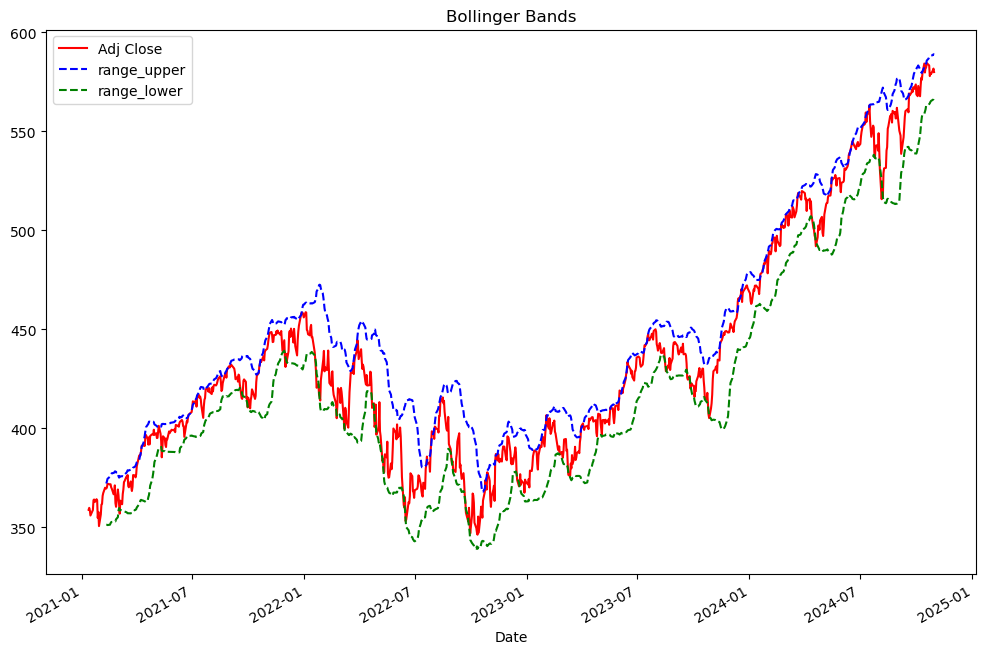

In [16]:
test_data_bollinger[['Adj Close' , 'range_upper' , 'range_lower' ]].plot(figsize = (12,8) , style = ['-', '--', '--'] , color = ('r' , 'b' , 'g'))
plt.title("Bollinger Bands")

In [17]:
# Bollinger Trade Signals
test_data_bollinger['positions'] =\
(
    np.where( (test_data_bollinger["Adj Close"] > test_data_bollinger['range_upper']) , -1 , np.nan)
)


test_data_bollinger['positions'] =\
(
    np.where( (test_data_bollinger["Adj Close"] < test_data_bollinger['range_upper']) , 1 ,  test_data_bollinger['positions'])
)    

test_data_bollinger['positions'] =\
(
    np.where( (test_data_bollinger['distance'] * test_data_bollinger['distance'].shift(1) ) < 0  , 0 , test_data_bollinger['positions'])
)



test_data_bollinger['positions'] = test_data_bollinger['positions'].ffill()

test_data_bollinger[test_data_bollinger['positions'] == -1].head()

,Open,High,Low,Close,Adj Close,Volume,daily_log_return,SMA_21,STDev_21,range_upper,range_lower,distance,positions
Date,,,,,,,,,,,,,
2021-04-05,403.459991,406.940002,403.380005,406.359985,386.334808,91684800,0.014251,372.889079,5.569446,384.027971,361.750186,13.445730,-1.0
2021-04-06,405.760010,407.239990,405.399994,406.119995,386.106689,62021000,-0.000591,373.963953,5.845110,385.654172,362.273734,12.142737,-1.0
2021-04-09,408.390015,411.670013,408.260010,411.489990,391.212036,61104600,0.007244,377.219577,6.715497,390.650572,363.788582,13.992459,-1.0
2021-05-07,419.890015,422.820007,419.160004,422.119995,401.318207,67733800,0.007252,395.394749,2.836119,401.066986,389.722512,5.923458,-1.0
2021-06-25,425.899994,427.089996,425.549988,426.609985,406.913818,58129500,0.003546,401.568432,2.614558,406.797548,396.339316,5.345386,-1.0


In [18]:
test_data_bollinger['log_return']=\
(
    np.log(test_data_bollinger["Adj Close"]
          /
          test_data_bollinger["Adj Close"].shift(1))
)

test_data_bollinger['strategy_return']=\
(
    test_data_bollinger['positions'].shift(1)
    *
    test_data_bollinger['log_return']
)

test_data_bollinger['cumulative_return']=\
(
    test_data_bollinger['strategy_return']
    .cumsum()
    .apply(np.exp)
)

test_data_bollinger['SPY_cumulative_return']=\
(
    test_data_bollinger['log_return']
    .cumsum()
    .apply(np.exp)
)

test_data_bollinger.dropna(inplace = True )

## <a id = "p1.3">1.3 </a> <font color = "green"> Machine Learning</font> [back to table of contents](#top)

### Outcome (Y)

In [21]:
return_period = 5

Y =\
(
    np
    .log(SPY['Adj Close'])
    .diff(return_period)
    .shift(-return_period)
)

Y.name =\
    ("SPY"
     +
     "_pred")

Y.tail(20)

Date
2024-10-03    0.014529
2024-10-04    0.011453
2024-10-07    0.028680
2024-10-08    0.011466
2024-10-09    0.008901
2024-10-10    0.010738
2024-10-11    0.008607
2024-10-14   -0.001182
2024-10-15    0.006087
2024-10-16   -0.007429
2024-10-17   -0.005355
2024-10-18   -0.009539
2024-10-21   -0.004809
2024-10-22   -0.002661
2024-10-23    0.003489
2024-10-24         NaN
2024-10-25         NaN
2024-10-28         NaN
2024-10-29         NaN
2024-10-30         NaN
Name: SPY_pred, dtype: float64

### Import X-features Data

In [23]:
def STOK(df, n):

    close = df["Adj Close"]
    low = df["Low"]
    high = df["High"]

    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    return STOK

def STOD(df, n):

    close = df["Adj Close"]
    low = df["Low"]
    high = df["High"]

    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100

    STOD = STOK.rolling(3).mean()
    return STOD

X8 = pd.concat(
    [
        STOK(SPY, 10),
        STOK(SPY, 30),
        STOK(SPY, 200),
        STOD(SPY, 10),
        STOD(SPY, 30),
        STOD(SPY, 200),
    ], axis=1)\
    .dropna()

X8.columns = ["STOK_10", "STOK_30", "STOK_200", "STOD_10", "STOD_30", "STOD_200"]

X8.dropna()

,STOK_10,STOK_30,STOK_200,STOD_10,STOD_30,STOD_200
Date,,,,,,
2006-08-21,-778.249670,-366.636486,-263.029717,-796.131507,-370.243206,-235.049832
2006-08-22,-778.410388,-366.721880,-263.092719,-775.311980,-365.075617,-248.447233
2006-08-23,-784.178794,-369.786781,-271.966574,-780.279617,-367.715049,-266.029670
2006-08-24,-808.605064,-370.723266,-272.669997,-790.398082,-369.077309,-269.243097
2006-08-25,-933.340619,-369.361098,-271.646830,-842.041492,-369.957049,-272.094467
...,...,...,...,...,...,...
2024-10-24,41.196601,74.203190,94.081716,50.358601,81.260481,94.903889
2024-10-25,39.487097,72.997616,93.909663,37.065516,74.281631,93.665942
2024-10-28,54.786560,79.115774,95.449481,45.156752,75.438860,94.480287


In [24]:
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series((M / N) * 100,
                    name = "ROC_" + str(n)
                    )
    return ROC

X9 = pd.concat(
    [
        ROC(SPY['Adj Close'], 10),
        ROC(SPY['Adj Close'], 30),

    ], axis=1)\
    .dropna()

X9.dropna()

,ROC_10,ROC_30
Date,,
2005-12-13,1.515035,5.660218
2005-12-14,0.884041,4.977385
2005-12-15,0.465143,4.228377
2005-12-16,0.355399,4.029021
2005-12-19,-0.349798,3.392259
...,...,...
2024-10-24,-0.058668,3.381909
2024-10-25,-0.903619,3.193812
2024-10-28,0.181101,3.470540


In [25]:
def MACD(data , column):
    ema_12 = data[column].ewm(span = 12, min_periods = 12).mean()
    ema_26 = data[column].ewm(span = 26, min_periods = 26).mean()

    macd = ema_12 - ema_26
    macd_signal =\
        (
            macd
            .ewm(span = 9)
            .mean()
        )
    return macd , macd_signal

SPY['MACD_Line'], SPY['Signal_Line'] = MACD(SPY , 'Adj Close')

# Bollinger Bands
SPY['MiddleBand'] = SPY['Adj Close'].rolling(window=20).mean()
SPY['StdDev'] = SPY['Adj Close'].rolling(window=20).std()
SPY['BB_High'] = SPY['MiddleBand'] + (SPY['StdDev'] * 2)
SPY['BB_Low'] = SPY['MiddleBand'] - (SPY['StdDev'] * 2)
SPY['%B'] = (SPY['Adj Close'] - SPY['BB_Low']) / (SPY['BB_High'] - SPY['BB_Low'])
SPY['Band_Width'] = SPY['BB_High'] - SPY['BB_Low']
SPY['Band_Position'] = (SPY['Adj Close'] - SPY['MiddleBand']) / SPY['Band_Width']

# Volatility
SPY['Volatility'] = SPY['daily_log_return'].rolling(window=20).std()

X10 = pd.concat(
    [
        SPY['MACD_Line'],
        SPY['Signal_Line'],
        SPY['%B'],
        SPY['Band_Width'],
        SPY['Band_Position'],
        SPY['Volatility']

    ], axis=1)\
    .dropna()

X10.columns = ['MACD_Line', 'Signal_Line', '%B', 'Band_Width', 'Band_Position', 'Volatility']

X10.dropna()

,MACD_Line,Signal_Line,%B,Band_Width,Band_Position,Volatility
Date,,,,,,
2005-12-07,0.434024,0.434024,0.623960,4.203599,0.123960,0.004864
2005-12-08,0.393027,0.411248,0.590590,3.747390,0.090590,0.004888
2005-12-09,0.372927,0.395543,0.633205,3.492969,0.133205,0.004671
2005-12-12,0.358937,0.383143,0.638342,3.290214,0.138342,0.004643
2005-12-13,0.387392,0.384407,0.798472,3.110866,0.298472,0.004794
...,...,...,...,...,...,...
2024-10-24,5.075070,5.700493,0.606836,23.376836,0.106836,0.006014
2024-10-25,4.664377,5.493270,0.583743,22.915026,0.083743,0.006000
2024-10-28,4.432248,5.281066,0.646438,22.914316,0.146438,0.005976


In [26]:
X=\
(
    pd
    .concat([X8, X9, X10],
            axis = 1)
)

X =\
(
    X.ffill()
)

In [27]:
data =\
(
  pd.concat([Y, X],axis = 1)
    .dropna()
    .iloc[ : :1, :]
)

Y =\
(
    data
    .loc[ : ,
         Y.name]
)


X = data.loc[ : , X.columns]

### Train, Test Split

In [29]:
validation_size = 0.2

train_size =\
    int(len(X)
        *
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size],
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size],
     Y[train_size:len(X)    ]
    )

### Fitting: Model Comparison with ML Algorithms

Step 3. For your algorithm of choices, please assess the model performance of the following algorithms:

* Linear Regression
* Elastic Net
* LASSO
* Support Vector Machine
* K-Nearest Neighbor
* ARIMA
* Decision Tree
* Extra Trees
* Random Forest
* Gradient Boosting Tree
* Adaptive Boosting

### Import Machine Learning Dependencies

In [31]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor


In [32]:
# for data split
from sklearn.model_selection import train_test_split

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

In [33]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [34]:
models = []

# Regression and tree regression algorithms
models.append(("LinearRegression", LinearRegression()))
models.append(("ElasticNet", ElasticNet()))
models.append(("LASSO", Lasso()))

In [35]:
### Initialization of Lists:

names = [] # store the names of the models,

# kfold_results = [] # store the cross-validation results,

train_results = [] # store the performance of the models on the training dataset
test_results = [] # store the performance of the models on the test dataset


### Looping through Models:

for name, model in models:

### Appending Model Names:

    names.append(name)

# Fitting the Model on the Entire Training Set:

    res = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

### Evaluating Model on Training Set:

# The trained model’s predictions on the training set are evaluated
# using the mean squared error, and the result is appended to train_results.

    train_result = mean_squared_error(res.predict(X_train), Y_train)

    train_results.append(train_result)

## Evaluating Model on Testing Set:

# Similarly, the model’s performance is evaluated
# on the testing set and appended to test_results.

    test_result = mean_squared_error(res.predict(X_test), Y_test)

    test_results.append(test_result)

# Printing the Results:

# Model performance comparison (MSE)
model_results = pd.DataFrame({
    "Model": names,
    "Train_MSE": [round(x, 4) for x in train_results],
    "Test_MSE": test_results
})


model_results.set_index("Model", inplace=True)

model_results


,Train_MSE,Test_MSE
Model,,
LinearRegression,0.0006,0.000527
ElasticNet,0.0007,0.000511
LASSO,0.0007,0.000511


### Model Comparison

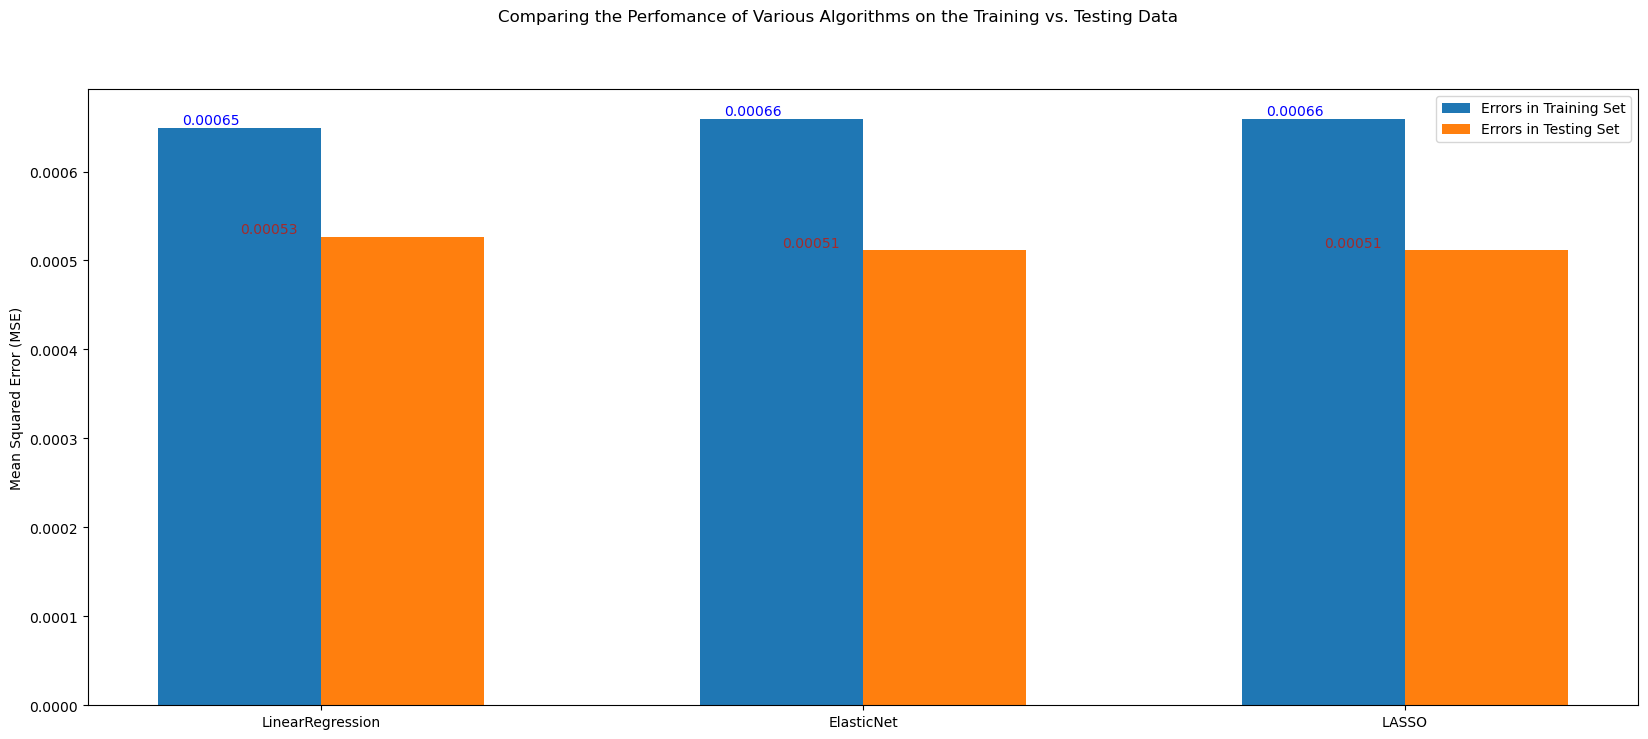

In [37]:
fig = plt.figure(figsize = [20, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

train_bars = (plt
 .bar(ind - width/2,
      train_results,
      width = width,
      label = "Errors in Training Set")
)

test_bars = (plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

# Add y-axis values on top of each bar
for bar, train_result, test_result in zip(train_bars, train_results, test_results):
    ax.text(bar.get_x() + bar.get_width() / 2, train_result, f'{train_result:.5f}', ha='right', va='bottom', fontsize=10,color='blue')
    ax.text(bar.get_x() + bar.get_width() / 2, test_result, f'{test_result:.5f}', ha='left', va='bottom', fontsize=10, color='brown')


plt.show()

In [38]:
# Elastic Net
EN_model = ElasticNet()
EN_model.fit(X_train, Y_train)
Predicted_EN = EN_model.predict(X_test)
EN_Predictions = pd.DataFrame({'Predicted': Predicted_EN}, index=Y_test.index)


# LASSO
LASSO_model = Lasso()
LASSO_model.fit(X_train, Y_train)
Predicted_LASSO = LASSO_model.predict(X_test)
LASSO_Predictions = pd.DataFrame({'Predicted': Predicted_LASSO}, index=Y_test.index)

#Linear Regression
LN_model = LinearRegression()
LN_model.fit(X_train, Y_train)
Predicted_LN = LN_model.predict(X_test)
LN_Predictions = pd.DataFrame({'Predicted': Predicted_LN}, index=Y_test.index)

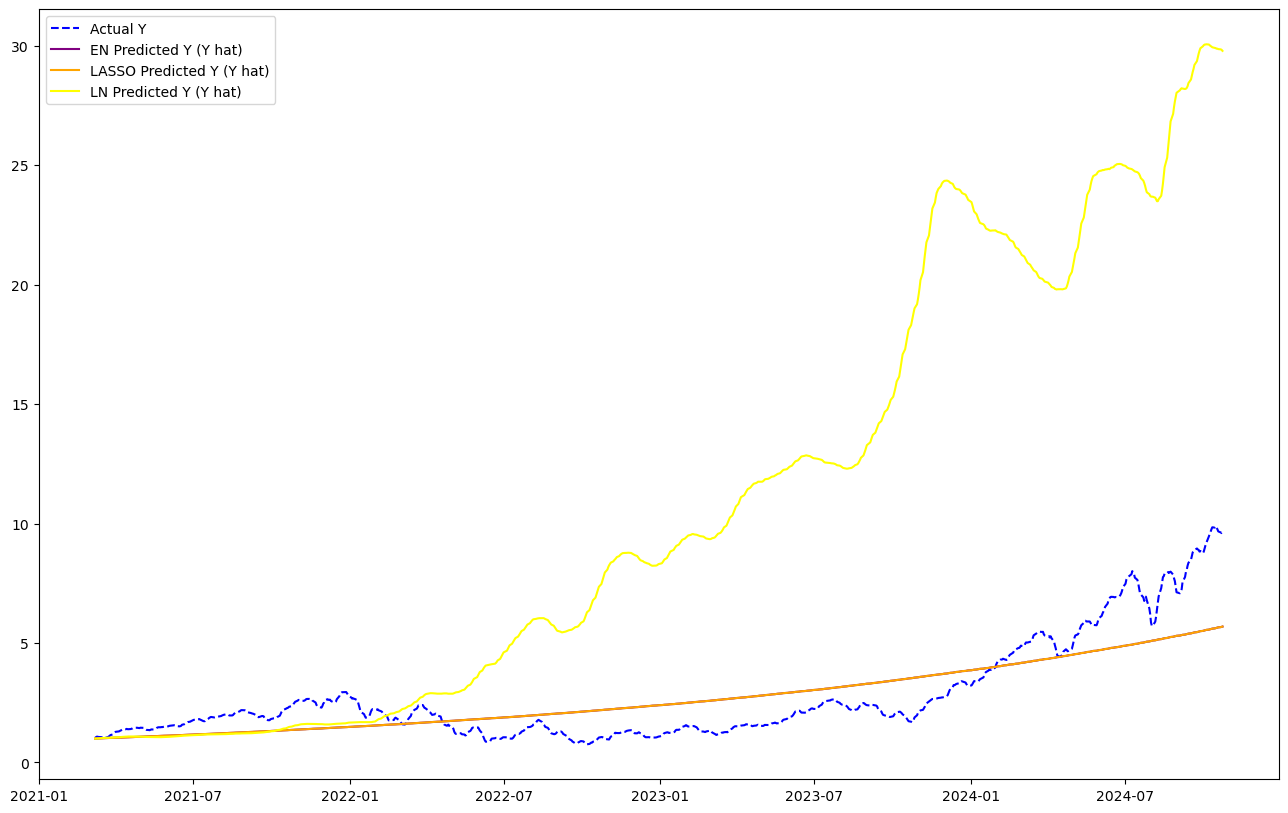

In [39]:
plt\
    .figure(figsize = (16, 10))

LN_Predictions.index = Y_test.index

plt\
    .plot(np.exp(Y_test).cumprod(),
          "b--",
          label = "Actual Y")

plt\
    .plot(np.exp(EN_Predictions).cumprod(),
          label = "EN Predicted Y (Y hat)", color = 'purple')

plt\
    .plot(np.exp(LASSO_Predictions).cumprod(),
          label = "LASSO Predicted Y (Y hat)", color = 'orange')

plt\
    .plot(np.exp(LN_Predictions).cumprod(),
          label = "LN Predicted Y (Y hat)", color = 'yellow')

plt\
    .legend()

plt\
    .show()

### Use LN as best model

In [41]:
capital = 100000
# Actual returns
LN_Predictions['Returns'] = SPY['Adj Close'].pct_change()

# Signal: Use predicted returns to define positions
LN_Predictions['positions'] =\
(
    np
    .where(LN_Predictions['Predicted'] > 0, 1, -1)
)

# Strategy Returns: Shift positions to prevent lookahead bias
LN_Predictions['strategy_returns'] =\
(
    LN_Predictions['positions'].shift(1) 
    * LN_Predictions['Returns']
)

Predictions = LN_Predictions['strategy_returns']

# Calculate cumulative returns of the strategy
LN_Predictions['strategy_cum_returns'] =\
(
    np
    .exp(LN_Predictions['strategy_returns'].cumsum())
)

# Compute the portfolio value over time
LN_Predictions['Strategy_portfolio_value'] =\
(
    capital 
    * LN_Predictions['strategy_cum_returns']
)

# Calculate cumulative returns of the strategy
LN_Predictions['cum_returns'] =\
(
    np
    .exp(LN_Predictions['Returns'].cumsum())
)

LN_Predictions['SPY_portfolio_value'] =\
(
    capital 
    * LN_Predictions['cum_returns']
)

## <a id = "p1.4">Other. </a> <font color = "green"> Momentum Strategy: MACD + RSI </font> [back to table of contents](#top)

In [43]:
def RSI(data):
    price_change = SPY['Adj Close'].diff().iloc[1: ]
    price_change
    
    gain = price_change.clip(lower = 0)
    loss = -price_change.clip(upper = 0)
    
    gain_loss =\
    (
        pd
        .concat([gain, loss],
                axis = 1)
    )
    
    g_rs_init, l_rs_init =\
    (
        gain_loss
        .iloc[ :14]
        .mean()
        .values
    )
    
    rs_init = g_rs_init / l_rs_init
    
    g_rs = g_rs_init
    l_rs = l_rs_init
    
    init_date = gain_loss.index[13]
    init_date_plus_1 = gain_loss.index[14]
    
    gl_rs_df =\
    (
        pd
        .DataFrame(
            {init_date: [g_rs, l_rs]},
            index = ["gain_rs", "loss_rs"]
        ).T
    )
    
    for d, (g, l) in gain_loss.loc[init_date_plus_1: ].iterrows():
        g_rs = ((g_rs * 13) + g) / 14
        l_rs = ((l_rs * 13) + l) / 14
        gl_rs_df.loc[d] = [g_rs, l_rs]
    
    gl_rs_df
    
    # convert rs to rsi
    
    rs =\
    (
        gl_rs_df["gain_rs"]
        /
        gl_rs_df["loss_rs"]
    )
    
    rsi = 100 - 100 / (1 + rs) # oscillator running between 0 and 100

    return rsi

In [44]:
def MACD(data , column):
    ema_12 = data[column].ewm(span = 12, min_periods = 12).mean()
    ema_26 = data[column].ewm(span = 26, min_periods = 26).mean()

    macd = ema_12 - ema_26
    macd_signal =\
        (
            macd
            .ewm(span = 9)
            .mean()
        )

    diff =\
    (
        macd
        -
        macd_signal
    )
    
    # if macd > signal, positive . if macd < signal , negative 
    
    # Position Cross Identification
    
    position_cross =\
    (
        np
        .sign(diff * diff.shift(1)
             ) == -1
    )

    position_macd_direction =\
    (
        np
        .sign(macd
              .diff()
             )
    )

    bullish = (position_macd_direction > 0) & position_cross

    bearish = (position_macd_direction < 0) & position_cross
    return bearish , bullish
    

In [45]:
#RSI
train_data['RSI'] = RSI(train_data)
test_data['RSI'] = RSI(test_data)

#MACD
train_data['macd_bearish'], train_data['macd_bullish'] = MACD(train_data , 'Adj Close')
test_data['macd_bearish'], test_data['macd_bullish'] = MACD(test_data , 'Adj Close')

In [46]:
# SPY['Bullish_Crossover'] = (SPY['MACD_Line'] > SPY['Signal_Line']) & (SPY['MACD_Line'].shift(1) <= SPY['Signal_Line'].shift(1))
train_data['Buy_Signal'] = (train_data['macd_bullish']) & (train_data['RSI'] < 50)
test_data['Buy_Signal'] = (test_data['macd_bullish']) & (test_data['RSI'] < 50)

# Bearish crossover: MACD Line < Signal Line (turning downward) AND RSI > 50
# SPY['Bearish_Crossover'] = (SPY['MACD_Line'] < SPY['Signal_Line']) & (SPY['MACD_Line'].shift(1) >= SPY['Signal_Line'].shift(1))
train_data['Sell_Signal'] = (train_data['macd_bearish']) & (train_data['RSI'] > 50)
test_data['Sell_Signal'] = (test_data['macd_bearish']) & (test_data['RSI'] > 50)

In [47]:
#Position
train_data['position'] = np.where(train_data['Buy_Signal'] , 1 , np.where(train_data['Sell_Signal'] , -1 , np.nan))
test_data['position'] = np.where(test_data['Buy_Signal'] , 1 , np.where(test_data['Sell_Signal'] , -1 , np.nan))

train_data.loc[train_data.index[0], "position"] = 0
test_data.loc[test_data.index[0], "position"] = 0

train_data["position"] =\
(
    train_data["position"]
    .ffill()
)

test_data["position"] =\
(
    test_data["position"]
    .ffill()
)


In [48]:
train_data.head()

,Open,High,Low,Close,Adj Close,Volume,daily_log_return,RSI,macd_bearish,macd_bullish,Buy_Signal,Sell_Signal,position
Date,,,,,,,,,,,,,
2005-11-01,120.580002,120.900002,120.220001,120.489998,83.991142,66365100,NaN,NaN,False,False,False,False,0.0
2005-11-02,120.169998,121.750000,120.129997,121.750000,84.869492,74012300,0.010403,NaN,False,False,False,False,0.0
2005-11-03,122.150002,122.660004,121.750000,122.269997,85.231934,84897600,0.004261,NaN,False,False,False,False,0.0
2005-11-04,122.400002,122.459999,121.550003,122.110001,85.120415,59156000,-0.001309,NaN,False,False,False,False,0.0
2005-11-07,122.370003,122.620003,121.849998,122.230003,85.204071,46765400,0.000982,NaN,False,False,False,False,0.0


In [49]:
train_data["log_return"] =\
(
    np
    .log(train_data['Adj Close']
         /
         train_data['Adj Close'].shift(1)
        )
)

test_data["log_return"] =\
(
    np
    .log(test_data['Adj Close']
         /
         test_data['Adj Close'].shift(1)
        )
)

train_data["strategy"] =\
(
    train_data["log_return"]
    *
    train_data["position"].shift(1)
)

test_data["strategy"] =\
(
    test_data["log_return"]
    *
    test_data["position"].shift(1)
)

test_data['cumulative_return']=\
(
    test_data['strategy']
    .cumsum()
    .apply(np.exp)
)

train_data['cumulative_return']=\
(
    train_data['strategy']
    .cumsum()
    .apply(np.exp)
)

#SPY returns
train_data['SPY_cumulative_return'] = train_data['log_return'].cumsum().apply(np.exp)
test_data['SPY_cumulative_return'] = test_data['log_return'].cumsum().apply(np.exp)


# <a id = "p2"> </a> <font color = "green"> PART2. BACKTESTING AND PERFORMANCE </font>  [back to table of contents](#top)

### <a id = "p2">1.1 </a> <font color = "green"> Trend Strategy: Simple MA + MACD result</font> [back to table of contents](#top)/ [back to strategy](#p1.1)

In [52]:
#capital=100,000
capital = 1e5

#train data return calculation
train_datasma["daily_return"] = np.log(train_datasma["Adj Close"] / train_datasma["Adj Close"].shift(1))
train_datasma["strategy_return"] = train_datasma["position"].shift(1) * train_datasma["daily_return"]
train_datasma["cumulative_return"] = (train_datasma["strategy_return"].cumsum().apply(np.exp)) 

#test data return calculation
test_datasma["daily_return"] = np.log(test_datasma["Adj Close"] / test_datasma["Adj Close"].shift(1))
test_datasma["strategy_return"] = test_datasma["position"].shift(1) * test_datasma["daily_return"]
test_datasma["cumulative_return"] = (test_datasma["strategy_return"].cumsum().apply(np.exp))

# final capital
final_capital = test_datasma["cumulative_return"].iloc[-1]*capital

# benchmark: SPY cumulative return
SPY["cumulative_return"] = (SPY["daily_log_return"][train_size:].cumsum().apply(np.exp))

# final cumulative return comparison
final_strategy_cumulative_return = test_datasma["cumulative_return"].iloc[-1]
final_spy_cumulative_return = SPY["cumulative_return"].iloc[-1]

# Sharpe Ratio
sharpe_ratio = np.sqrt(252) * (test_datasma["strategy_return"].mean() / test_datasma["strategy_return"].std())

# CAGR
days = (test_datasma.index[-1] - test_datasma.index[0]).days
cagr = np.exp(test_datasma["strategy_return"].sum()) ** (365 / days) - 1

# strategy max drawdown
test_datasma["Max_performance"] = test_datasma["cumulative_return"].cummax()
test_datasma["Drawdown"] = -(test_datasma["cumulative_return"] - test_datasma["Max_performance"]) / test_datasma["Max_performance"]
max_drawdown = test_datasma["Drawdown"].max()

# SPY MAX Drawdown comparison
SPY["Max_performance"] = SPY["cumulative_return"].cummax()
SPY["Drawdown"] = -(SPY["cumulative_return"] - SPY["Max_performance"]) / SPY["Max_performance"]
baseline_max_drawdown = SPY["Drawdown"].max()


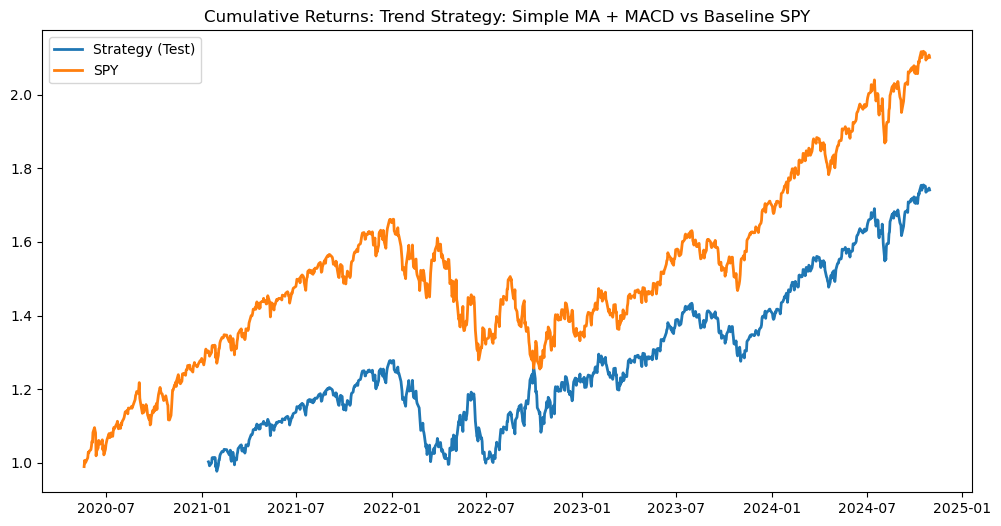

SPY Cumulative Return: 2.10
Strategy Cumulative Return: 1.74
Final Capital: $174104.93
Sharpe Ratio: 0.88
CAGR: 15.71%
Max Drawdown: 22.09%


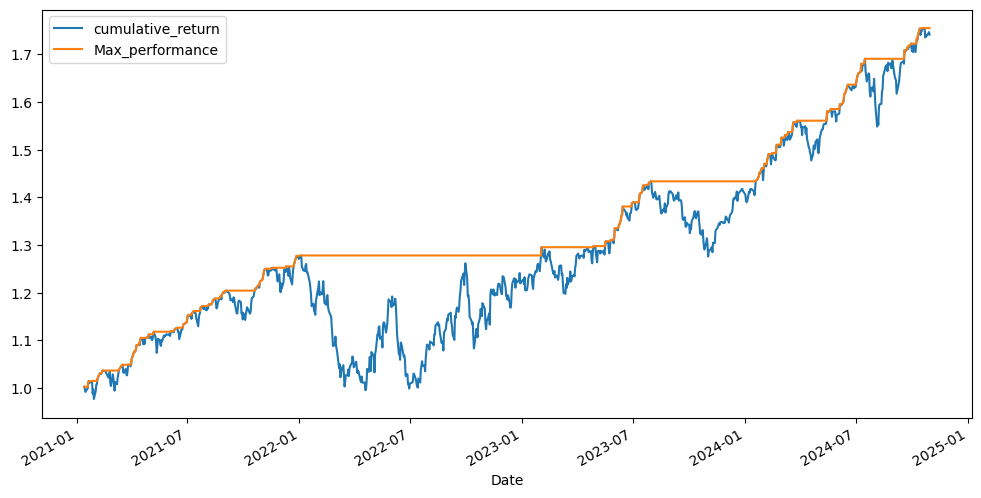

In [53]:
# plot cumulative return (SPY & Strategy MACD+SMA)
plt.figure(figsize=(12, 6))
plt.plot(test_datasma["cumulative_return"], label="Strategy (Test)", linewidth=2)
plt.plot(SPY["cumulative_return"], label="SPY", linewidth=2)
plt.title("Cumulative Returns: Trend Strategy: Simple MA + MACD vs Baseline SPY")
plt.legend()
plt.show()

# Maximum Drawdown plot
test_datasma[["cumulative_return", "Max_performance"]].dropna().plot(figsize = [12, 6])

# Performance
print(f"SPY Cumulative Return: {final_spy_cumulative_return:.2f}")
print(f"Strategy Cumulative Return: {final_strategy_cumulative_return:.2f}")
print(f"Final Capital: ${final_capital:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")


### <a id = "p1.2">1.2 </a> <font color = "green"> Mean Reversion Strategy: Bollinger Bands result </font> [back to table of contents](#top) / [back to strategy](#p1.2) 

In [55]:
capital = 100000

# final capital
bollinger_capital = test_data_bollinger["cumulative_return"].iloc[-1]*capital


# final cumulative return comparison
bollinger_strategy_cumulative_return = test_data_bollinger["cumulative_return"].iloc[-1]
bollinger_spy_cumulative_return = test_data_bollinger["SPY_cumulative_return"].iloc[-1]

#Sharpe Ratio
bollinger_sharpe_ratio = \
(
    np.sqrt(252) 
    * # scaling factor
    (test_data_bollinger["strategy_return"].mean())
    /
    (test_data_bollinger["strategy_return"].std())
)



# CAGR
days = (test_data_bollinger.index[-1] - test_data_bollinger.index[0]).days
bollinger_cagr = np.exp(test_data_bollinger["strategy_return"].sum()) ** (365 / days) - 1

# strategy max drawdown
test_data_bollinger["Max_performance"] = test_data_bollinger["cumulative_return"].cummax()
test_data_bollinger["Drawdown"] = -(test_data_bollinger["cumulative_return"] - test_data_bollinger["Max_performance"]) / test_data_bollinger["Max_performance"]
bollinger_max_drawdown = test_data_bollinger["Drawdown"].max()

# SPY MAX Drawdown comparison
test_data_bollinger["SPY_Max_performance"] = test_data_bollinger["SPY_cumulative_return"].cummax()
test_data_bollinger["SPY_Drawdown"] = -(test_data_bollinger["SPY_cumulative_return"] - test_data_bollinger["SPY_Max_performance"]) / test_data_bollinger["SPY_Max_performance"]
bollinger_baseline_max_drawdown = test_data_bollinger["SPY_Drawdown"].max()


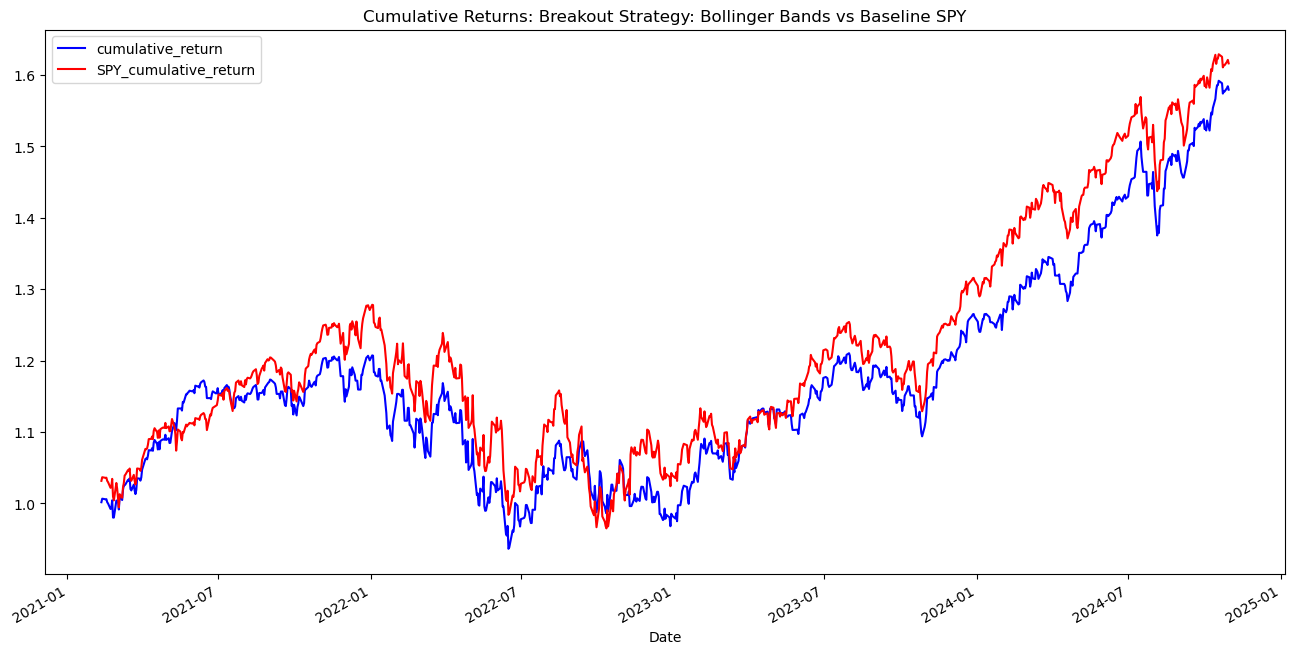

SPY Cumulative Return: 1.62
Strategy Cumulative Return: 1.58
Final Capital: $157912.51
Sharpe Ratio: 0.80
CAGR: 13.08%
Max Drawdown: 22.43%


<Axes: xlabel='Date'>

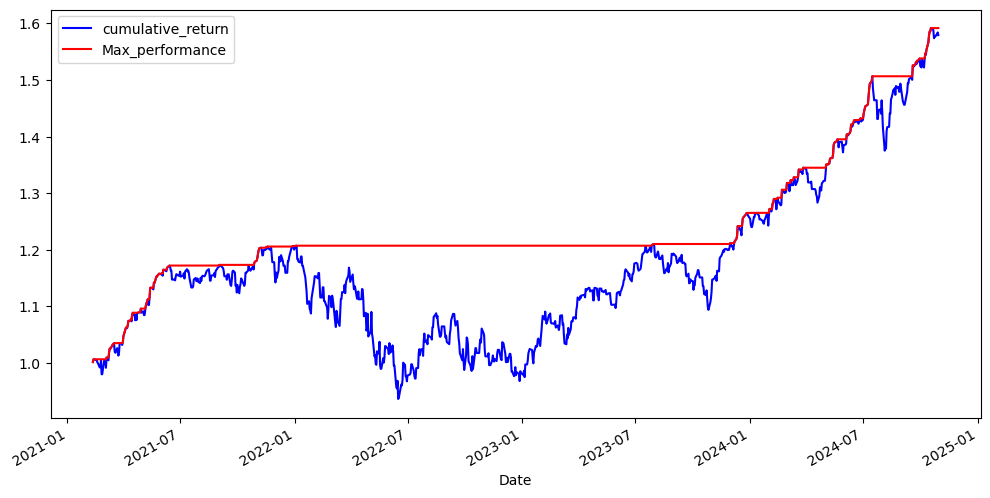

In [56]:
test_data_bollinger[['cumulative_return' , 'SPY_cumulative_return']].plot(figsize=(16,8) , color = ('b' , 'r') )
plt.title("Cumulative Returns: Breakout Strategy: Bollinger Bands vs Baseline SPY")
plt.legend()
plt.show()

# Performance
print(f"SPY Cumulative Return: {bollinger_spy_cumulative_return:.2f}")
print(f"Strategy Cumulative Return: {bollinger_strategy_cumulative_return:.2f}")
print(f"Final Capital: ${bollinger_capital:.2f}")
print(f"Sharpe Ratio: {bollinger_sharpe_ratio:.2f}")
print(f"CAGR: {bollinger_cagr:.2%}")
print(f"Max Drawdown: {bollinger_max_drawdown:.2%}")

# Maximum Drawdown plot
test_data_bollinger[["cumulative_return", "Max_performance"]].dropna().plot(figsize = [12, 6] , color = ('b' , 'r'))

### <a id = "p1.3">1.3 </a> <font color = "green"> Machine Learning result </font> [back to table of contents](#top) / [back to strategy](#p1.3)

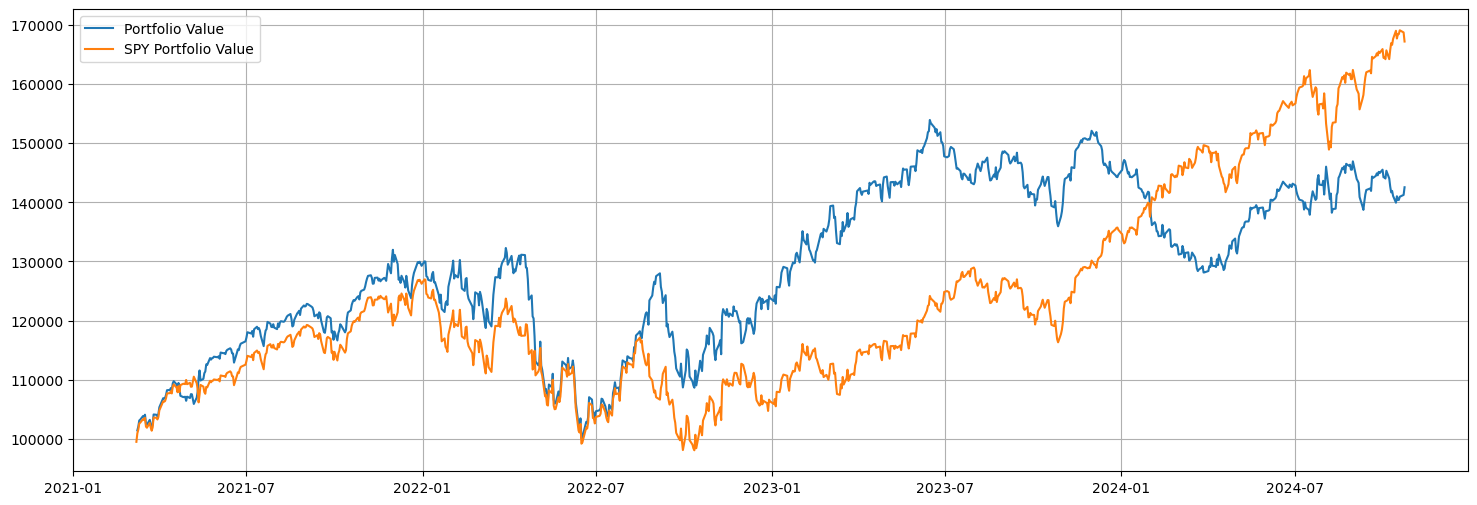

In [58]:
plt\
    .figure(figsize=(18, 6))

plt\
    .plot(LN_Predictions.index, 
          LN_Predictions['Strategy_portfolio_value'], 
          label ='Portfolio Value')

plt\
    .plot(LN_Predictions.index, 
          LN_Predictions['SPY_portfolio_value'], 
          label='SPY Portfolio Value')

plt.legend()

plt.grid()

plt.show()

In [59]:
# Check MSE
mse = mean_squared_error(Y_test, LN_Predictions[['Predicted']])

# final capital
ln_capital = LN_Predictions['Strategy_portfolio_value'].iloc[-1]

# Drop NaNs introduced by shift
LN_Predictions.dropna(inplace=True)

# Performance Metrics
def calculate_metrics(data):
    # Sharpe Ratio
    sharpe_ratio = data.mean() / data.std() * np.sqrt(252)  # Annualized

    # Maximum Drawdown (MDD)
    cumulative_returns = (1 + data).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = cumulative_returns - peak / peak
    max_drawdown = drawdown.min()

    # CAGR
    total_return = cumulative_returns.iloc[-1]
    years = len(data) / 252
    cagr = total_return ** (1 / years) - 1

    return sharpe_ratio, max_drawdown, cagr

ln_str_cum_returns = LN_Predictions['strategy_cum_returns'].iloc[-1]
ln_spy_cum_returns = LN_Predictions['cum_returns'].iloc[-1]

# Calculate strategy metrics
strategy_sr, strategy_mdd, strategy_cagr = calculate_metrics(Predictions)

# Print metrics
print(f"Strategy Metrics:\nSharpe Ratio: {strategy_sr:.2f}\nMDD: {strategy_mdd:.2%}\nCAGR: {strategy_cagr:.2%}")
print(f'SPY Cumulative Returns: {ln_spy_cum_returns}')
print(f'Strategy Cumulative Returns: {ln_str_cum_returns}')
print("Final Capital: ", ln_capital)
print(f'Mean Squared Error: {mse}')


Strategy Metrics:
Sharpe Ratio: 0.59
MDD: -1.96%
CAGR: 8.74%
SPY Cumulative Returns: 1.6718423636595505
Strategy Cumulative Returns: 1.425465041009267
Final Capital:  142546.50410092672
Mean Squared Error: 0.0005266347594086224


In [60]:
LN_Predictions

,Predicted,Returns,positions,strategy_returns,strategy_cum_returns,Strategy_portfolio_value,cum_returns,SPY_portfolio_value
Date,,,,,,,,
2021-03-09,0.002023,0.014278,1,0.014278,1.014380,101437.991455,1.009342,100934.189557
2021-03-10,0.002422,0.006225,1,0.006225,1.020714,102071.393106,1.015644,101564.445356
2021-03-11,0.002454,0.010139,1,0.010139,1.031116,103111.567867,1.025995,102599.453986
2021-03-12,0.004121,0.001347,1,0.001347,1.032505,103250.511006,1.027377,102737.707049
2021-03-15,0.003792,0.005964,1,0.005964,1.038681,103868.116268,1.033522,103352.244914
...,...,...,...,...,...,...,...,...
2024-10-17,0.000005,0.000086,1,-0.000086,1.404022,140402.173121,1.684368,168436.797945
2024-10-18,-0.000592,0.003847,-1,0.003847,1.409433,140943.280264,1.690859,169085.949966
2024-10-21,-0.000388,-0.001642,-1,0.001642,1.411749,141174.929460,1.688085,168808.502515


### <a id = "p1.4">1.4 </a> <font color = "green"> Momentum Strategy: MACD + RSI result </font> [back to table of contents](#top) / [back to strategy](#p1.4) 

In [62]:
capital = 100000
macd_rsi_strategy_capital = test_data["cumulative_return"].iloc[-1]*capital
SPY_captial = test_data["SPY_cumulative_return"].iloc[-1]*capital


# final cumulative return comparison
macd_rsi_strategy_cumulative_return = test_data["cumulative_return"].iloc[-1]
macd_rsi_cumulative_return = test_data["SPY_cumulative_return"].iloc[-1]


# Sharpe Ratio
macd_rsi_sharpe_ratio = np.sqrt(252) * (test_data["strategy"].mean() / test_data["strategy"].std())

# CAGR
macd_rsi_days = (test_data.index[-1] - test_data.index[0]).days
macd_rsi_cagr = np.exp(test_data["strategy"].sum()) ** (365 / days) - 1

# strategy max drawdown
test_data["Max_performance"] = test_data["cumulative_return"].cummax()
test_data["Drawdown"] = -(test_data["cumulative_return"] - test_data["Max_performance"]) / test_data["Max_performance"]
macd_rsi_max_drawdown = test_data["Drawdown"].max()

# SPY MAX Drawdown comparison
test_data["SPY_Max_performance"] = test_data["SPY_cumulative_return"].cummax()
test_data["SPY_Drawdown"] = -(test_data["SPY_cumulative_return"] - test_data["SPY_Max_performance"]) / test_data["SPY_Max_performance"]
macd_rsi_baseline_max_drawdown = test_data["SPY_Drawdown"].max()


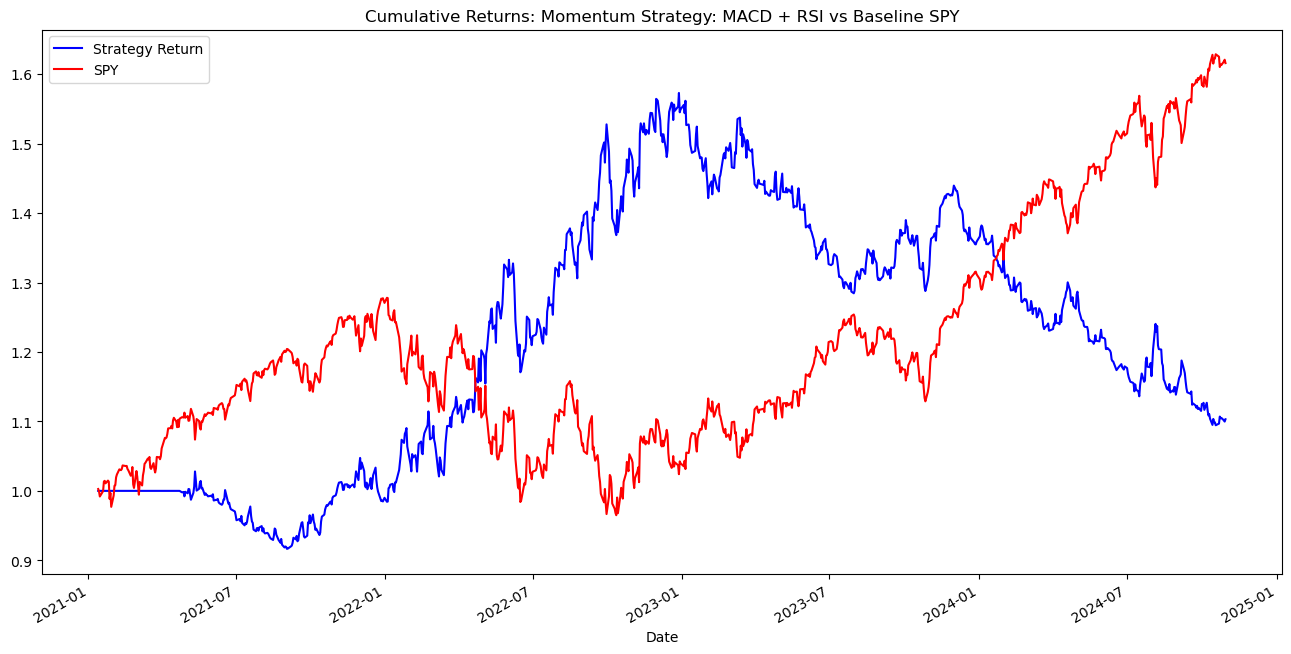

SPY Cumulative Return: 1.62
Strategy Cumulative Return: 1.10
Final Capital: $110313.47
Sharpe Ratio: 0.16
CAGR: 2.68%
Max Drawdown: 30.42%


<Axes: xlabel='Date'>

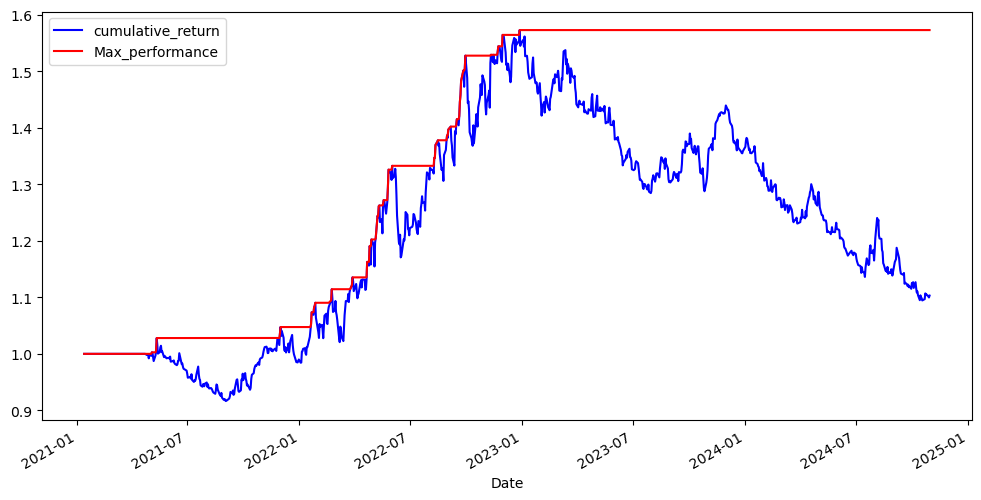

In [63]:
# plot returns
test_data["cumulative_return"].plot(figsize = (16,8) , color ='b' , label="Strategy Return")
test_data["SPY_cumulative_return"].plot(figsize = (16,8) , color ='r' , label="SPY")
plt.title("Cumulative Returns: Momentum Strategy: MACD + RSI vs Baseline SPY")
plt.legend()
plt.show()

# Performance
print(f"SPY Cumulative Return: {macd_rsi_cumulative_return:.2f}")
print(f"Strategy Cumulative Return: {macd_rsi_strategy_cumulative_return:.2f}")
print(f"Final Capital: ${macd_rsi_strategy_capital:.2f}")
print(f"Sharpe Ratio: {macd_rsi_sharpe_ratio:.2f}")
print(f"CAGR: {macd_rsi_cagr:.2%}")
print(f"Max Drawdown: {macd_rsi_max_drawdown:.2%}")

# Maximum Drawdown plot
test_data[["cumulative_return", "Max_performance"]].dropna().plot(figsize = [12, 6] , color = ('b' , 'r'))

### <a id = "p1.5">Other. </a> <font color = "green"> Agnes Clustering strategy & result</font> [back to table of contents](#top)

In [65]:
ETF = ['SPY','QQQ', 'DIA' , 'XLY', 'XLP', 'XLE', 'XLF' , 'XLK' , 'XLV' , 'XLI' , 'XLB' , 'XLRE' , 'VIX' ,'IWM', 'EEM', 'IEUR', 'EWJ',
      	'TLT', 'HYG' , 'GLD' , 'USO', 'AAPL', 'MSFT', 'TSLA' , 'NVDA' , 'AMZN'] 
tickers = yf.download(ETF , start, end)
tickers.index = tickers.index.tz_localize(None)

[*********************100%***********************]  26 of 26 completed


In [66]:
def extract_all(stocks, start, end):
    def extract_single_ticker(ticker):
        return(yf
               .download(ticker, 
                               start,
                               end)
               )
    interim_df = map(extract_single_ticker, stocks)
    return(pd
           .concat(interim_df,
                  keys = stocks,
                  names = ["ticker", "date"]
                 )
          )

In [67]:
tickers =\
    extract_all(ETF,
                start,
                end)
tickers =\
(
    tickers # DF
    [["Adj Close"]] # DF
    .reset_index()
    .pivot(index = "date", # from long format data to wide format data
           columns = 'ticker',
           values = "Adj Close") 
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [68]:
# Data Split
#Split training (80%) and backtesting (20%)
validation_size = 0.20
agnes_train_size = int(len(tickers) * (1 - validation_size))
agnes_train_data, agnes_test_data = tickers[:agnes_train_size].copy(), tickers[agnes_train_size:].copy()

In [69]:
# Removing missing data
missing_fractions = \
    agnes_train_data \
    .isnull() \
    .mean() \
    .sort_values(ascending = False)

drop_list =\
    sorted(list(missing_fractions
                [missing_fractions > 0.3]
                .index)
           )

agnes_train_data = agnes_train_data.drop(labels= drop_list,axis=1)
agnes_train_data = agnes_train_data.ffill()

In [70]:
returns =\
(
    agnes_train_data
    .pct_change()
    .mean() 
    * 252
)

returns = pd.DataFrame(returns)

returns.columns = ["Returns"]

returns["Volatility"] =\
(    
     agnes_train_data
    .pct_change()
    .std() 
    * np.sqrt(252)
)


data =\
( 
    np 
    .asarray([np.asarray(returns['Returns']),
              np.asarray(returns['Volatility'])
             ]
            )
    .T
)
returns

,Returns,Volatility
ticker,,
AAPL,0.337178,0.329610
AMZN,0.359912,0.385700
DIA,0.114695,0.194423
EEM,0.111763,0.303737
EWJ,0.059586,0.212938
GLD,0.105000,0.185777
HYG,0.059259,0.120173
IWM,0.122449,0.249157
MSFT,0.200267,0.279118


In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(returns)

rescaledDataset =\
(
    pd
    .DataFrame(scaler.fit_transform(returns),
               columns = returns.columns, 
               index = returns.index)
    
)

# summarize transformed data
X = rescaledDataset
X.head()

,Returns,Volatility
ticker,,
AAPL,1.892018,0.896544
AMZN,2.107500,1.543698
DIA,-0.216790,-0.663213
EEM,-0.244586,0.598027
EWJ,-0.739140,-0.449587


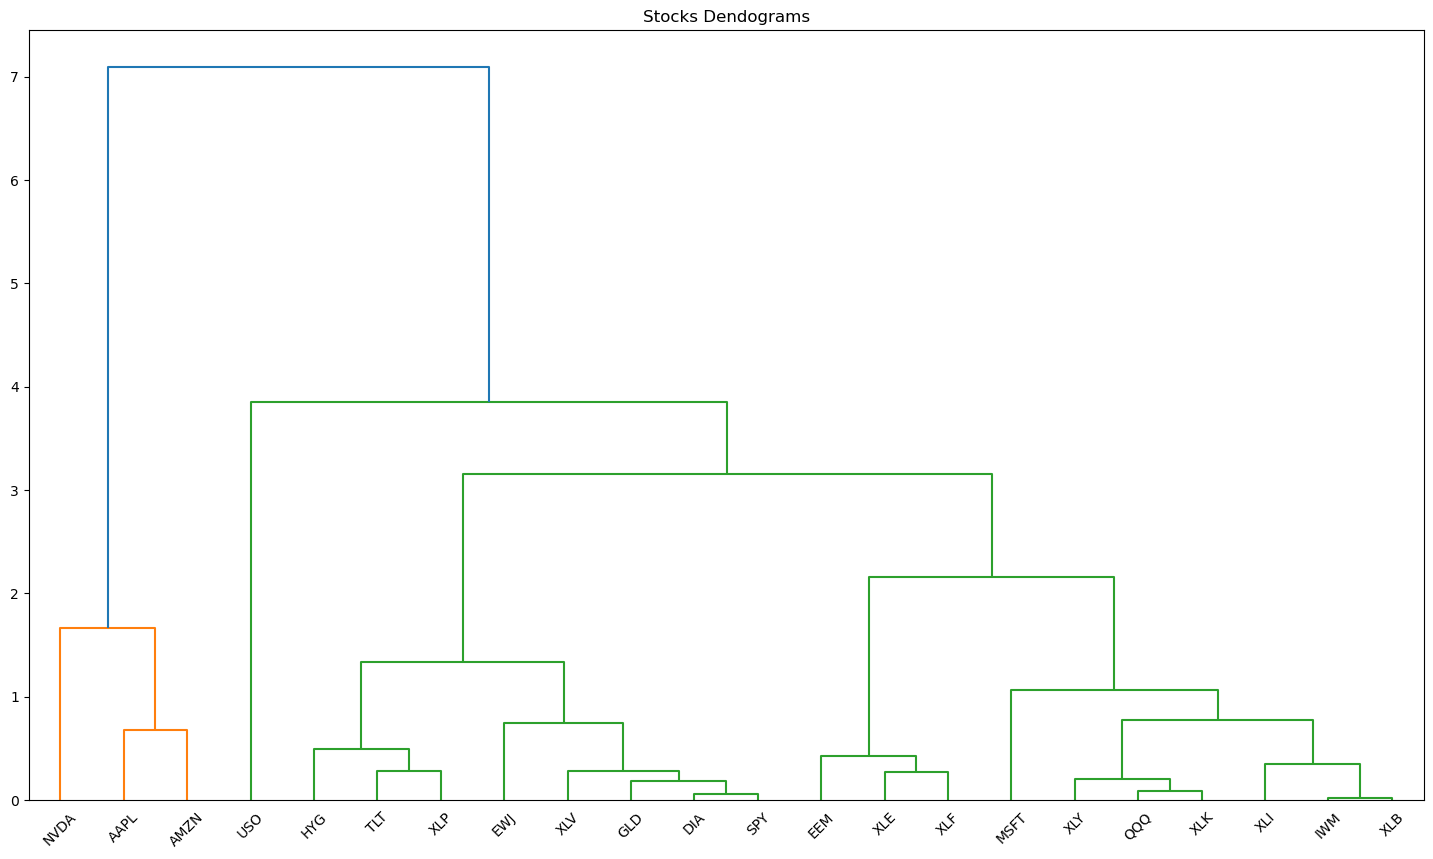

In [72]:
# Agnes Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z = linkage(X, 
            method = "ward")
Z[0]

# Plot Dendogram

plt.figure(figsize=(18, 10))
plt.title("Stocks Dendograms")
dendrogram(Z, labels = X.index)
plt.show()

In [73]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Step 1: Regress SPY on DIA to find the residual
y = agnes_test_data['SPY']
x = agnes_test_data['DIA']
x = sm.add_constant(x)  # Add constant term
model = sm.OLS(y, x).fit()
residuals = model.resid

# Step 2: Test the residuals for stationarity
adf_result = adfuller(residuals)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Interpret the p-value
if adf_result[1] < 0.05:
    print("The pair is cointegrated (reject null hypothesis).")
else:
    print("The pair is NOT cointegrated (fail to reject null hypothesis).")

#however pairs are not cointegrated which also there will be no mean reversion between the 2 asset. 

ADF Statistic: -2.679038587837049
p-value: 0.07773627469434184
The pair is NOT cointegrated (fail to reject null hypothesis).


In [74]:
pair_train_data =  agnes_train_data[['SPY' , 'DIA']]
pair_test_data = agnes_test_data[['SPY' , 'DIA']]
pair_test_data

ticker,SPY,DIA
date,,
2021-01-12,358.928864,288.867310
2021-01-13,359.895477,288.765076
2021-01-14,358.635071,288.225891
2021-01-15,356.019714,286.550049
2021-01-19,358.815186,287.666138
...,...,...
2024-10-24,579.239990,423.522461
2024-10-25,579.039978,420.884064
2024-10-28,580.830017,423.812286


In [75]:
import statsmodels.api as sm
y = pair_test_data['SPY'] 
x = pair_test_data['DIA'] 
x = sm.add_constant(x)  
model = sm.OLS(y, x).fit()

beta = model.params['DIA']

pair_test_data['Spread'] = pair_test_data['SPY'] - beta * pair_test_data['DIA']

In [76]:
# Calculating z-score of the spread
spread_mean = pair_test_data['Spread'].mean()
spread_std = pair_test_data['Spread'].std()
pair_test_data['Z_Score'] = (pair_test_data['Spread'] - spread_mean) / spread_std

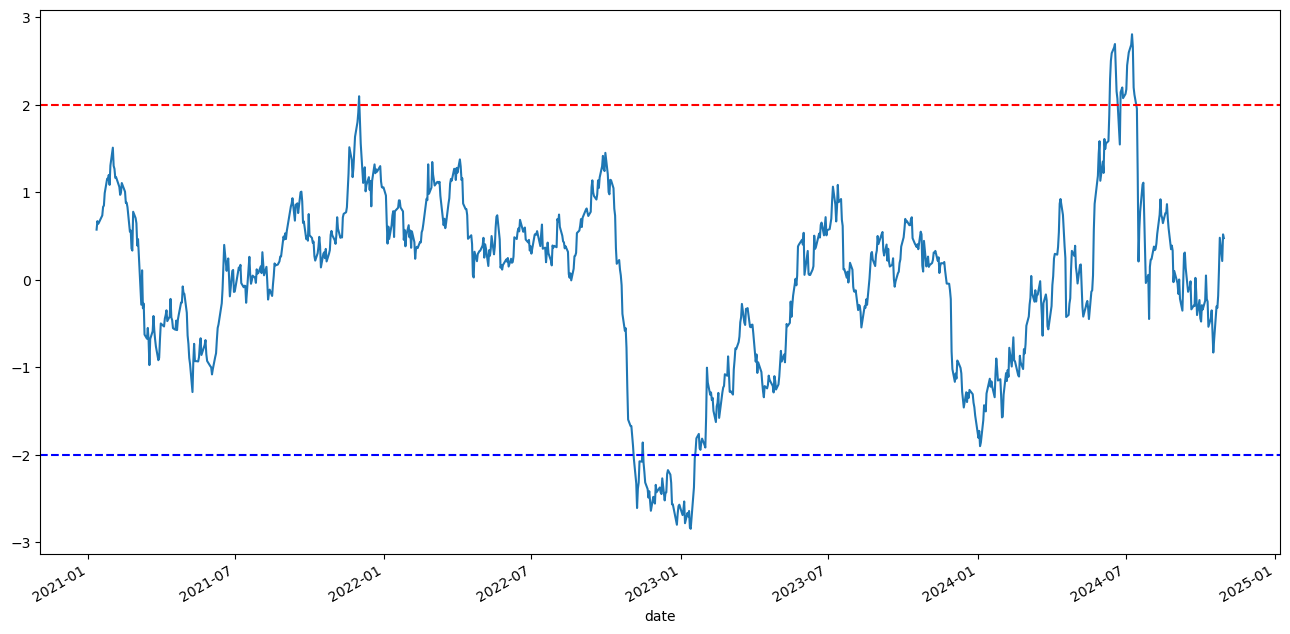

In [77]:
# Generate buy/sell signals for SPY
pair_test_data['positions'] = 0
pair_test_data.loc[pair_test_data['Z_Score'] > 2, 'positions'] = -1  # Sell SPY
pair_test_data.loc[pair_test_data['Z_Score'] < -2, 'positions'] = 1  # Buy SPY

pair_test_data['Z_Score'].plot(figsize = (16,8))
plt.axhline(y=2, color='red', linestyle='--',  label='Upper Threshold')
plt.axhline(y=-2, color='blue', linestyle='--', label='Lower Threshold')

In [78]:
pair_test_data['log_return']=\
(
    np.log(pair_test_data['SPY']
          /
          pair_test_data['SPY'].shift(1))
)

pair_test_data['strategy_return']=\
(
    pair_test_data['positions'].shift(1)
    *
    pair_test_data['log_return']
)

pair_test_data['cumulative_return']=\
(
    pair_test_data['strategy_return']
    .cumsum()
    .apply(np.exp)
)

pair_test_data['SPY_cumulative_return']=\
(
    pair_test_data['log_return']
    .cumsum()
    .apply(np.exp)
)

pair_test_data.dropna(inplace = True )

In [79]:
capital = 100000

# final capital
agnes_capital = pair_test_data["cumulative_return"].iloc[-1]*capital


# final cumulative return comparison
agnes_strategy_cumulative_return = pair_test_data["cumulative_return"].iloc[-1]
agnes_spy_cumulative_return = pair_test_data["SPY_cumulative_return"].iloc[-1]

#Sharpe Ratio
agnes_sharpe_ratio = \
(
    np.sqrt(252) 
    * # scaling factor
    (pair_test_data["strategy_return"].mean())
    /
    (pair_test_data["strategy_return"].std())
)



# CAGR
days = (pair_test_data.index[-1] - pair_test_data.index[0]).days
agnes_cagr = np.exp(pair_test_data["strategy_return"].sum()) ** (365 / days) - 1

# strategy max drawdown
pair_test_data["Max_performance"] = pair_test_data["cumulative_return"].cummax()
pair_test_data["Drawdown"] = -(pair_test_data["cumulative_return"] - pair_test_data["Max_performance"]) / pair_test_data["Max_performance"]
agnes_max_drawdown = pair_test_data["Drawdown"].max()

# SPY MAX Drawdown comparison
pair_test_data["SPY_Max_performance"] = pair_test_data["SPY_cumulative_return"].cummax()
pair_test_data["SPY_Drawdown"] = -(pair_test_data["SPY_cumulative_return"] - pair_test_data["SPY_Max_performance"]) / pair_test_data["SPY_Max_performance"]
agnes_baseline_max_drawdown = pair_test_data["SPY_Drawdown"].max()


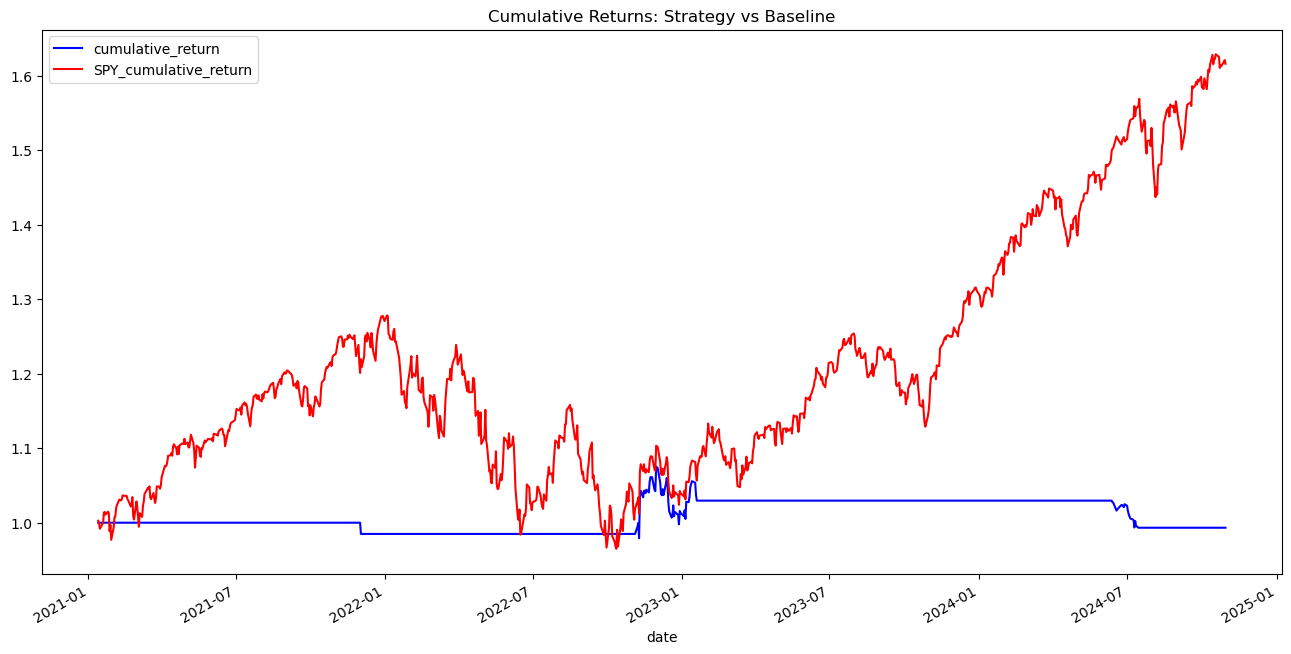

SPY Cumulative Return: 1.62
Strategy Cumulative Return: 0.99
Final Capital: $99323.82
Sharpe Ratio: -0.04
CAGR: -0.18%
Max Drawdown: 7.62%


<Axes: xlabel='date'>

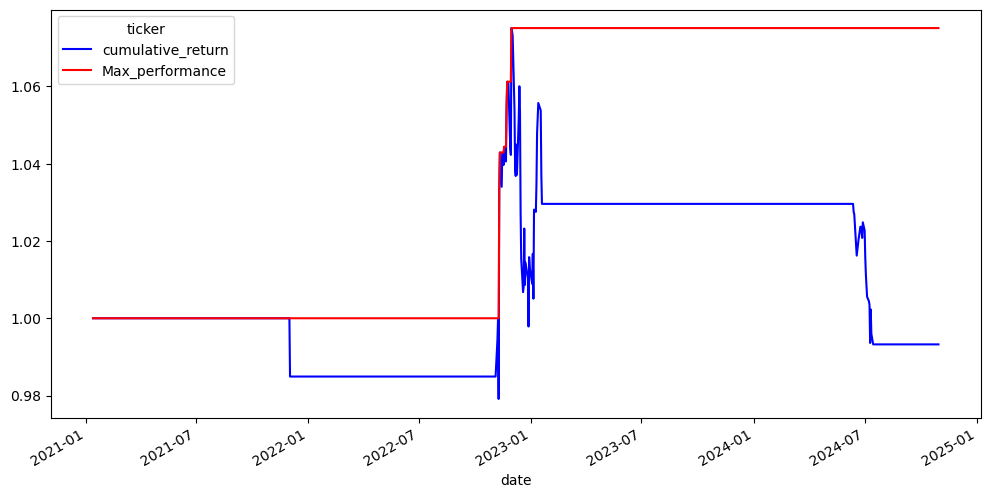

In [80]:
pair_test_data[['cumulative_return' , 'SPY_cumulative_return']].plot(figsize=(16,8) , color = ('b' , 'r') )
plt.title("Cumulative Returns: Strategy vs Baseline")
plt.legend()
plt.show()

# Performance
print(f"SPY Cumulative Return: {agnes_spy_cumulative_return:.2f}")
print(f"Strategy Cumulative Return: {agnes_strategy_cumulative_return:.2f}")
print(f"Final Capital: ${agnes_capital:.2f}")
print(f"Sharpe Ratio: {agnes_sharpe_ratio:.2f}")
print(f"CAGR: {agnes_cagr:.2%}")
print(f"Max Drawdown: {agnes_max_drawdown:.2%}")

# Maximum Drawdown plot
pair_test_data[["cumulative_return", "Max_performance"]].dropna().plot(figsize = [12, 6] , color = ('b' , 'r'))

However, returns here were negative. We will talk about it more in Extra Reading section.

# <a id = "p3"> </a> <font color = "green"> PART3. EXECUTIVE SUMMARY </font>  [back to table of contents](#top)

### <a id = "p3"> </a> <font color = "green"> 1. Trend Strategy: Simple MA + MACD </font> [back to table of contents](#top)/[back to strategy](#p1.1)

Strategy 1 is built based on the combination of Simple Moving Average (SMA) and Moving Average Convergence Divergence (MACD) to capture long term trends with short term momentum.  

 

`Results`: 

SPY Cumulative Return: 1.62 

Strategy Cumulative Return: 1.74  

Final Capital: $174,105.01 

Strategy Sharpe Ratio: 0.88 

CAGR: 15.71% 

Max Drawdown: 22.09% 
 

`Explanation of Strategy`: 

We apply a 10-day short term average and 200-day long term average as the SMA indicator to detect market trends, while the momentum shifts are captured by the MACD, which compares the 12-day and 26-day exponential moving averages with a 9-day signal line. The signals from these two indicators were then combined to create trading positions; thus, the buy signal indicates positive trends and the sell signal indicates downward movements. We assume this strategy provides both trend following and momentum benefits. 

 

`Explanation of Result`: 

The performance results from backtesting on test data show that this strategy has the potential to outperform the market, with a cumulative return of 1.74 and a CAGR of 15.71%, exceeding SPY’s cumulative return of 1.62 and other strategies. In addition, the Sharpe Ratio of 0.88 indicates a reasonable return for the level of risk taken. However, this strategy faces a maximum drawdown of 22.09%, suggesting that while it is profitable, it can be exposed to significant risks during market downturns. 

 

### <a id = "p3"> </a> <font color = "green"> 2. Mean Reversion Strategy: Bollinger Bands </font> [back to table of contents](#top)/[back to strategy](#p1.2)

For our second strategy, we focused on solely using the mean reversion strategy bollinger bands to generate the trading signals.  

 
`Results`:  

SPY Cumulative Return: 1.62 

Strategy Cumulative Return: 1.58 

Final Capital: $157,912.26 

Strategy Sharpe Ratio: 0.80

SPY Sharpe Ratio: 0.73 

CAGR: 13.08% 

Max Drawdown: 22.43% 

 
`Thresholds`: 

SMA : Rolling window of 21 days  

Bollinger Bands: Threshold of 2 Standard Deviation from the simple moving average  

 

`Explanation of Strategy`:  

In this mean reversion strategy, we are trading on the assumption that SPY price will revert to their mean after significant deviations. Thus, we created the signals such that we sell when SPY was overbought (SMA above the 2 SD threshold) and to buy when SPY was underbought (SMA below the 2 SD threshold). For the simple moving average, a rolling window of 21 days was chosen to capture more recent price signals. The downside is that when there are more signals, there may be an increase in false positives, especially in a volatile market. Thus, we added in another signal which is to set a neutral position when trend is unclear. This is a risk control mechanism to prevent overtrading and limit losses by not trading during price fluctuations.  

 

`Explanation of Results`:  

For backtesting, we took 20% of the most recent year data and calculated the cumulative returns. With the bollinger bands strategy, we managed to generate returns of 1.56% as compared to the market return of 1.62%. Even though, the strategy did not outperform the market, the strategy has a slightly higher sharpe ratio of 0.8 as compared to SPY sharpe ratio of 0.73. Meaning it managed to generate more returns per unit of risk, making it more appealing to risk-averse investors.  Among our 3 strategies, strategy 1 still has the best outcome. It managed to beat the market and had higher returns and CAGR. Additionally, strategy 1 worst-loss case (maximum drawdown) was lower than our current strategy and has a higher sharpe ratio, making it a more suitable strategy for risk averse investors than strategy 2.   
 

### <a id = "p3"> </a> <font color = "green"> 3. Machine Learning </font> [back to table of contents](#top)/[back to strategy](#p1.3)

Last strategy used, was a combination of Supervised Machine Learning, and momentum strategy. Linear Regression Model was chosen as the best model, as it has the lowest training set MSE, and its test set MSE, is lower than the training set, but the closest, which means it is neither underfitted or overfitted  

`Results`:

SPY Cumulative Returns: 1.67

Strategy Cumulative Returns: 1.43

Final Capital:  142,546.46

Strategy Sharpe Ratio: 0.59 

CAGR: 8.74% 

Maximum Drawdown: -1.96%

Mean Squared Error: 0.0005266346587126386 

 

`Explanation of Strategy`:

This trading strategy applies machine learning and technical analysis to predict future price movements of the S&P 500 ETF (SPY) and execute trades accordingly. The intuition behind the strategy lies in leveraging historical market patterns and technical indicators to make data-driven decisions. It uses a variety of features that capture price momentum, trend strength, and volatility, aiming to identify favorable conditions for buying or selling. 

The strategy begins by calculating technical indicators such as the Stochastic Oscillator (%K, %D), ROC, MACD , Bollinger Bands, and rolling volatility. These features are designed to encapsulate market behavior over various timeframes. For example, %K and %D measure momentum, while Bollinger Bands gauge price deviation from its mean. This multi-faceted approach ensures the model has inputs capturing both directional trends and mean-reverting tendencies. 

A machine learning regression model predicts future returns based on these features. The prediction serves as the basis for trading signals: a positive forecast triggers a long position (buy), while a negative forecast initiates a short position (sell). This logic is built on the assumption that the machine learning model can exploit repeatable patterns in the relationship between technical indicators and future returns. 

The strategy’s risk management is evident in its low maximum drawdown (-1.96%), suggesting it avoids significant losses by dynamically adjusting positions based on predictions. However, its moderate Sharpe Ratio (0.59) and CAGR (8.74%) indicate only modest success in achieving risk-adjusted returns. While it grows the portfolio to $142,546, it underperforms the SPY benchmark, highlighting potential inefficiencies in the linear model’s ability to capture complex market dynamics. 

 

`Explanation of Results`: 

Sharpe Ratio (0.59): This ratio measures the risk-adjusted return of the strategy. A Sharpe Ratio above 1.0 is typically desirable, indicating strong returns relative to risk. Here, 0.59 suggests moderate performance, as the model's predictions yield returns with significant risk or suboptimal reward per unit of risk. 

Maximum Drawdown (MDD -1.96%): The strategy experienced a maximum peak-to-trough decline of 1.96%. This low MDD indicates the strategy effectively minimizes downside risk, likely due to stable or well-timed predictions. 

Compound Annual Growth Rate (CAGR 8.74%): The model achieves annualized growth of 8.74%, reflecting its ability to consistently generate positive returns over time. However, this is slightly lower than the SPY (S&P 500 ETF) benchmark's cumulative return of 67.18% over the same period, suggesting the strategy underperforms the broader market. 

Cumulative Returns (1.425): The strategy results in a total return of 42.5%, growing capital from 100,000 to 142,546, compared to SPY’s 67.2%. This highlights potential inefficiencies in the linear regression model's predictive power compared to market performance. 

Mean Squared Error (0.0005): The low MSE suggests the model fits the training data well but does not guarantee strong predictive accuracy for out-of-sample data. 

In summary, the strategy's moderate Sharpe Ratio and underperformance relative to SPY may stem from linear regression’s limitations in capturing nonlinear market dynamics or missing key features affecting returns. 

 

### <a id = "p3"> </a> <font color = "green"> Conclusion - Top Strategy Selection: </font> 

We selected the Trend Strategy: SMA+MACD as our Top Strategy, as it achieved the highest cumulative return (1.74) and CAGR (15.71%), outperforming both the SPY and other strategies. In addition, its Sharpe ratio of 0.88 reflects a favorable risk-return tradeoff, making it the most ideal choice overall.

# <a id = "p4"> </a> <font color = "green"> PART4. SELF-CRITIQUE </font>  [back to table of contents](#top)

`SMA`:

The short-term and long-term periods of the simple moving average are important considerations when evaluating an approach. When these periods differ by only one day, questions arise about the practicality and usefulness of the adopted criteria. In an unstable market, such a subtle difference may not capture the relevant patterns and provide a solid basis for decision-making. In order to ensure more comprehensive research and improve the adaptability of your strategy and ability to respond to market fluctuations, it is important to examine the difference in time periods and extend them as necessary. By appropriately identifying these time periods, you can create a stronger and more reliable framework for guiding your investment decisions. 

`MACD`: 

The Moving Average Convergence/Divergence (MACD) is a powerful tool for analyzing market trends and identifying potential entry and exit points. However, the effectiveness of strategies based on MACD depends greatly on the choice of short-term and long-term Exponential Moving Average (EMA) periods. If these periods are too close together, the resulting MACD line may fail to capture important market trends or provide actionable signals, especially in volatile or rapidly changing markets. 

In volatile markets, the subtle differences between short-term and long-term exponential moving averages (EMAs) can create misleading crossovers that lead to false signals. To address this issue, it is important to evaluate and optimize the period of the EMA based on historical data and the characteristics of the market you are trading. Increasing the difference between the two periods helps to eliminate noise and capture broader trends, while decreasing the difference may be better suited to identifying shorter-term fluctuations. 

 
In addition, the period of the signal line (usually the 9-day EMA of the MACD line) should also be carefully considered. Extending or shortening this period will affect the sensitivity of the strategy and how quickly the system responds to changes in the market. 

By carefully adjusting these parameters and extensively backtesting, you can develop a more adaptable and robust trading framework. An optimized MACD strategy will not only improve the accuracy of market signals, but also enhance your ability to respond to changing conditions, ultimately supporting more confident and informed investment decisions. 

### <a id = "p4"> </a> <font color = "green"> 1. Trend Strategy: Simple MA + MACD </font> [back to table of contents](#top)

Strategy 1 relies heavily on trend-following indicators, which may generate false signals in non trending market, where price movements lack  a clear direction. In addition, SMA and MACD are lagging indicators, leading to delayed reactions when facing unexpected market regime shifts. This reliance increases the risk of significant drawdowns during volatile markets. To improve this strategy, we can add mean-reversion indicators to make it more adaptable to different market conditions. 

### <a id = "p4"> </a> <font color = "green"> 2. Mean Reversion Strategy: Bollinger Bands </font> [back to table of contents](#top)

Bollinger band strategy is useful when it comes to capturing trends and volatility driven by regime shift. However, like strategy 1, one of the most major downsides of this strategy is that it is a lagging indicator. It heavily relies on past price and volatility data and is not able to react to new, unforeseen events. Factors like pandemics (COVID-19) , Fed rate decisions, sudden market shocks may fail to be captured by bollinger band, leading to false signals being generated.  One way to overcome this is to pair the mean-reversion strategy with a trend indicator such as MACD. 

### <a id = "p4"> </a> <font color = "green"> 3. Machine Learning </font> [back to table of contents](#top)

Although supervised machine learning is useful to some extent, it is by no means able to predict the future, as it is heavily reliant on past trends, which is a look-ahead bias from historical data. This would lead to an inability or diffiuclties in handling with big volatility jumps.  

There are difficulties with finding the right features to suit strategies. Though supervised ML is a great tool, it cannot be used as a standalone trading strategy.  

The other big difficulty is handling the data before and after modelling, as there may be some missing data, if not cleaned properly would affect the model. 

# <a id = "p5"> </a> <font color = "green"> Extra Reading </font>  [back to table of contents](#top)

In this section, we will be touching on other strategies that were attempted but not included in the top 3 strategies. We will also be writing a short description as to what went wrong.  

### <a id = "p5"> </a> <font color = "green"> Other Strategies 1. Momentum Strategy: MACD + RSI [back to table of contents](#top)

`Results`:

SPY Cumulative Return: 1.62 

Strategy Cumulative Return: 1.10 

Final Capital: $110313.47 

Sharpe Ratio: 0.16 

CAGR: 2.62% 

Max Drawdown: 30.42% 

 
`Explanation of Strategy`:  

In this strategy we combine trend indicator MACD and RSI indicator to create our trading signals. When MACD indicates a bullish trend through the ewm and RSI indicates that the asset is underbought ( RSI < 50 ) , we create a signal to buy. Similarly, when MACD indicates a bearish trend and RSI indicates asset is overbought (RSI > 50), we create a signal to sell.  

`Why strategy was not chosen?`  

Returns in this strategy were low as compared to the others and the sharpe ratio also signified a significantly lower return per unit of risk. Thus, making it not a ideal strategy to implement. The strategy was also moving inversely to the market and extremely sensitive to short-term price movements, potentially leading to over-trading or false signals during volatile market conditions. A way to improve this might be to use more tight constraints on the RSI. instead of taking > 50 as overbought and < 50 as underbought.  

### <a id = "p4"> </a> <font color = "green"> Other Strategies 2. Agnes Clustering [back to table of contents](#top)

`Results`:

SPY Cumulative Return: 1.62 

Strategy Cumulative Return: 0.99 

Final Capital: $99323.82 

Sharpe Ratio: -0.04 

CAGR: -0.18% 

Max Drawdown: 7.62% 

 

`Explanation of Strategy`:  

In this strategy, we attempted to use cointegration between indices to generate trading signals. We first identified the ETF most closely related to SPY through AGNES clustering.We grouped ETFs based on similarity metrics (returns and volatility), helping us find the most comparable ETF to SPY. Once the most related ETF was identified, we leveraged the concept of cointegration, which suggests that the price difference (spread) between two cointegrated assets will fluctuate around a constant mean over time. Using the Z-score of the spread, we generated trading signals under the assumption that the spread would mean revert. Buy SPY when the spread is < -2 and sell SPY when the spread is > 2. 

`Why strategy was not chosen? `

The most obvious reason was that we ended up losing money and also sharpe ratio was negative. Meaning our strategy is performing worse than a risk-free investment. When carrying out pairs trading, one of the most important step is to ensure the pairs are cointegrated. In our case, the ADF test was not passed when the significance level was 5% but it passed the test at 10%. There is not strong enough evidence to show that DIA and SPY are cointegrated, in that case there would be no mean reversion between their spread. Thus, leading to a loss in our strategy. One way to resolve this is to expand our ETF choices to find an even more suitable coingrated pair. 

# <a id = "p6"> </a> <font color = "green"> Contribution Statement </font>  [back to table of contents](#top)

***** Group 12 *****

MATSUO TOSHIHIRO: Supported in developing machine learning strategy and cross-checked all strategies. Reviewed the code and assisted the team as needed. Actively participated in discussions.

LIM JIE MIN JERMAYNE: Responsible for creating Bollinger Bands, MACD+RSI, and AGNES clustering strategies, as well as writing the executive summary and self-critique for these strategies. Actively engaged in strategy discussions with team members to improve and refine each approach.

CHANG WEN-YU: Worked on developing the SMA+MACD and Bollinger Bands strategies, and contributed to writing the executive summaries and self-critiques. Collaborated closely with team members on strategy discussions.

NASRUDDIN ISLAM BIN RAMLI: Led the development of the machine learning and mean reversion strategy, and contributed to writing the executive summary and self-critique for these strategies. Actively participated in reviewing strategies, and contributing insights during team discussions.